# Import necessary Libraries

In [2]:
# Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
    
# Set a random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.layers import Input, Conv1D, Flatten, Dense, LSTM
from keras.models import Model
from keras.models import clone_and_build_model
from keras.callbacks import EarlyStopping

# Helper Functions 

In [18]:
def sliding_window(data, window_size, stride):
    """
    Extracts sliding window segments from time-series data for each class label.

    Parameters:
    - data (DataFrame): Input time-series data with columns representing features and a 'Fault_class' column for labels.
    - window_size (int): Size of the sliding window.
    - stride (int): Number of data points to move the sliding window at each step.

    Returns:
    - R (array): Array of sliding window segments.
    - Y (array): Array of corresponding labels for each segment.
    - pseudo_label (array): Array of incidence vector (C) for each segment.
    """
    
    # Initialize variables to store the segments and labels
    
    residuals = []
    labels = []
    C = []
    
    # Iterate over each class label in the data
    for label in data['Fault_class'].unique():
        # Get the data for the current class label
        class_data = data[data['Fault_class'] == label].iloc[30:]
    
        # Iterate over the data
        for i in range(0, len(class_data) - window_size, stride):
            # Get the current segment and label
            
            residual = class_data.iloc[i:i+window_size,1:7]
            
            label = class_data.iloc[i+window_size][-1]

            c = class_data.iloc[i+window_size,7:-1]
        
            # Add the segment and label to the list
            residuals.append(residual)
            labels.append(label)
            C.append(c)
    
    R,Y,pseudo_label= np.array(residuals),  np.array(labels), np.array(C)

    
    # Return the segments and labels
    return R,Y,pseudo_label

def DeepLearningModel(InputFeature, Target, last_layer_activation, loss_fn):
    """
    Create a deep learning model using Convolutional Neural Network (CNN) architecture.

    Parameters:
    - InputFeature (numpy.ndarray): Input features with shape (batch_size, sequence_length, feature_dim).
    - Target (numpy.ndarray): Target values with shape (batch_size, num_classes).
    - last_layer_activation (str): Activation function for the output layer. Common choices: 'sigmoid' for binary classification, 'softmax' for multi-class classification.
    - loss_fn (str): Loss function to optimize during training. Common choices: 'binary_crossentropy' for binary classification, 'categorical_crossentropy' for multi-class classification.

    Returns:
    - nn_model (tensorflow.keras.models.Model): Compiled Keras model for deep learning.

    Example:
    ```python
    # Example usage:
    model = DeepLearningModel(InputFeature, Target, 'sigmoid', 'binary_crossentropy')
    ```
    """
    # Define input layer
    input_layer = Input(shape=(InputFeature.shape[1], InputFeature.shape[2]))

    # Define CNN layers with batch normalization in between
    cnn1 = Conv1D(32, 3, padding='same', activation='relu')(input_layer)
    cnn1 = Conv1D(32, 3, padding='same', activation='relu')(cnn1)
    cnn1 = Flatten()(cnn1)

    # Define hidden layer with batch normalization
    hidden_layer = Dense(units=64, activation='relu')(cnn1)

    # Define output layer with specified activation function
    outputs = Dense(Target.shape[1], activation=last_layer_activation)(hidden_layer)

    # Define the model
    nn_model = Model(inputs=input_layer, outputs=outputs)

    # Compile the model with specified loss function and Adam optimizer
    nn_model.compile(loss=loss_fn, optimizer='adam', metrics=['binary_accuracy'])

    return nn_model

def Resample(X_sc, Y, Z, num_samples):
    """
    Resample the input data to balance the class distribution.

    Parameters:
    - X_sc (numpy.ndarray): Input data array. If 2D, it represents features; if 3D, it represents features over time steps.
    - Y (numpy.ndarray): Array of labels corresponding to each data point in X_sc.
    - Z (numpy.ndarray): Additional information array with the same number of features as X_sc.
    - num_samples (int): Number of samples to be resampled for each unique class label.

    Returns:
    - tuple: A tuple containing resampled data arrays (x_sample, y_sample, z_sample).
      - x_sample (numpy.ndarray): Resampled input data array.
      - y_sample (numpy.ndarray): Resampled array of labels.
      - z_sample (numpy.ndarray): Resampled additional information array.

    Notes:
    - The function uses sklearn.utils.resample to resample data for each unique class label.
    - Assumes Z has the same number of features as X_sc.

    Example:
    >>> X_resampled, Y_resampled, Z_resampled = resample(X_train, Y_train, Z_train, num_samples=1000)
    """
    # Check if the input data is 2D or 3D
    if len(X_sc.shape) == 3:
        num_features = X_sc.shape[1]
        num_time_steps = X_sc.shape[2]
        x_sample = np.zeros((num_samples * np.unique(Y).size, num_features, num_time_steps))
    else:
        num_features = X_sc.shape[1]
        x_sample = np.zeros((num_samples * np.unique(Y).size, num_features))
    y_sample = np.zeros(num_samples * np.unique(Y).size)
    z_sample = np.zeros((num_samples * np.unique(Y).size, Z.shape[1]))  # Assuming Z has the same number of features as X

    for i, label in enumerate(np.unique(Y)):
        class_indices = np.where(Y == label)[0]
        sampled_indices = resample(class_indices, n_samples=num_samples, replace=False, random_state=0)
        x_sample[i*num_samples:(i+1)*num_samples] = X_sc[sampled_indices]
        y_sample[i*num_samples:(i+1)*num_samples] = Y[sampled_indices]
        z_sample[i*num_samples:(i+1)*num_samples] = Z[sampled_indices]

    return x_sample, y_sample, z_sample


def FineTunedModel(nn_model,x_train,y_train,X_sc,Y_ohe):
    """
    Fine-tunes a neural network model by adding and training additional layers on top of
    the intermediate layer of the provided base model.

    Parameters:
    - nn_model (tf.keras.Model): The base neural network model to be fine-tuned.
    - x_train (numpy.ndarray): The input training data.
    - y_train (numpy.ndarray): The target training data.
    - X_sc (numpy.ndarray): The input validation data for model evaluation.
    - Y_ohe (numpy.ndarray): The target validation data for model evaluation, one-hot encoded.

    Returns:
    - tf.keras.Model: The fine-tuned model.

    The function performs the following steps:
    1. Creates a clone of the base model and sets its weights.
    2. Constructs an intermediate model by removing the last two layers from the clone.
    3. Freezes the layers of the intermediate model.
    4. Adds new layers to the intermediate model for fine-tuning.
    5. Compiles the model with categorical cross-entropy loss and the Adam optimizer.
    6. Trains the model on the training data with freezed layers for 500 epochs.
    7. Unfreezes the layers for further training.
    8. Creates a custom Adam optimizer with a small learning rate.
    9. Recompiles the model with the custom optimizer.
    10. Retrains the model on the training data with unfreezed layers for 50 epochs.
    11. Returns the fine-tuned model.

    Note:
    The function uses early stopping with patience set to 5 to monitor validation loss
    and restore the best weights during training.
    """

    from keras.layers import BatchNormalization
    from keras.models import clone_and_build_model

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model_copy= clone_and_build_model(nn_model)
    model_copy.set_weights(weights=nn_model.get_weights())

    intermediate_model = Model(inputs=model_copy.input,outputs=model_copy.layers[-2].output)

    for l in intermediate_model.layers:
        l.trainable=False

    fine_tuned_layers = Dense(units=64,activation='relu')(intermediate_model.output)
    output_layer = Dense(units=Y_ohe.shape[1],activation='softmax')(fine_tuned_layers)

    # Define the model
    fine_tuned_model = Model(inputs=intermediate_model.input, outputs=output_layer)

    # Compile the model with binary cross-entropy loss function and Adam optimizer
    fine_tuned_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #categorical_hinge

    #train the model with freezed layer
    history1=fine_tuned_model.fit(x_train, y_train, epochs=500, batch_size=int(len(x_train) * 0.2), validation_data=(X_sc[::50], Y_ohe[::50]), callbacks=[early_stop], verbose=0)

    for l in fine_tuned_model.layers:
        l.trainable=True

    # Create a custom Adam optimizer with a small learning rate
    custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

    # Compiling again is necessary to update the trainable parameter before training
    fine_tuned_model.compile(loss='categorical_crossentropy', optimizer=custom_optimizer, metrics=['accuracy']) #categorical_hinge

    #train the model with unfreezed layer
    history2=fine_tuned_model.fit(x_train, y_train, epochs=50, batch_size=int(len(x_train) * 0.2), validation_data=(X_sc[::50], Y_ohe[::50]), verbose=0)

    return fine_tuned_model

def preprocess_inferance(data,scaler,window_size, stride):
    """
    Preprocesses input data for inference.

    Args:
    - data (DataFrame): Input DataFrame containing time-series data.
    - scaler: A scaler object (e.g., from scikit-learn) for normalizing the input data.
    - window_size (int): Size of the sliding window used to extract segments from the time-series data.
    - stride (int): The step size for moving the sliding window.

    Returns:
    - R (numpy.ndarray): Processed residual segments.
    - Y (numpy.ndarray): Corresponding labels for each segment.
    - C (numpy.ndarray): Additional features (context) for each segment.
    - Time (numpy.ndarray): Timestamps corresponding to each segment.

    This function iterates over the input data and extracts segments of the specified window size
    with a specified stride. It normalizes the segments using the provided scaler and returns the
    processed residuals (R), labels (Y), context features (C), and timestamps (Time).
    """
    residuals = []
    labels = []
    Time = []
    C = []
    # Iterate over the data
    for i in range(0, len(data) - window_size, stride):
        # Get the current segment and label
        
        residual = data.iloc[i:i+window_size,1:7]
        
        label = data.iloc[i+window_size][-1]

        c = data.iloc[i+window_size,7:-1]

        time = data.iloc[i+window_size,0]

        # Add the segment and label to the list
        residuals.append(residual)
        labels.append(label)
        C.append(c)
        Time.append(time)

    R,Y,C,Time= np.array(residuals),  np.array(labels), np.array(C), np.array(Time)

    R=scaler.transform(R.reshape(-1,R.shape[2])).reshape(R.shape)

    return R,Y,C,Time



def Cascade_Hybrid_FDI(Z,y_pred):
    """
    Perform Cascade Hybrid Fault Detection and Isolation (FDI).

    This function combines the predictions from a hybrid FDI system based on a set of fault signals Z
    and the predicted output values y_pred.

    Parameters:
    - Z (array-like): A 2D array representing the fault signals. Each row corresponds to a sample,
                     and each column represents a different fault signal. Non-zero values indicate the presence
                     of a fault.
    - y_pred (array-like): A 2D array representing the predicted output values. Each row corresponds to a sample,
                          and each column represents a different output dimension.

    Returns:
    - Cascade_hybrid_prediction (array-like): An array containing the final predictions after Cascade Hybrid FDI.
                                              If a fault is detected in a sample (sum of the corresponding row in Z is > 0),
                                              the prediction is taken from the first column of y_pred (index 0).
                                              Otherwise, the prediction is set to 0.
    """
    Cascade_hybrid_prediction=np.zeros(len(y_pred))

    for i,fs in enumerate(Z):
        if sum(fs)>0:
            Cascade_hybrid_prediction[i]=y_pred[i]

    return Cascade_hybrid_prediction

# Data preprocessing

In [13]:
data = pd.read_csv("Electrolyzer_faults.csv")
# Use sliding window to segment the entire data into small portions
X,Y,Z = sliding_window(data, window_size=10, stride=1)

# Standardization of the input data to [-1,1]
sc= StandardScaler()
X_sc=sc.fit_transform(X.reshape(-1,X.shape[2])).reshape(X.shape)

# One hot encoding of the labels
ohe = OneHotEncoder(sparse=False)
Y_ohe = ohe.fit_transform(Y.reshape(-1,1))

x_train, x_test, z_train, z_test = train_test_split(X_sc, Z, test_size=0.2)

# SSL Step 1: Pretraining using pseudo labels

Epoch 1/500
29/29 [==============================] - 2s 40ms/step - loss: 0.5005 - binary_accuracy: 0.8205 - val_loss: 0.3300 - val_binary_accuracy: 0.9106
Epoch 2/500
29/29 [==============================] - 0s 12ms/step - loss: 0.2350 - binary_accuracy: 0.9297 - val_loss: 0.1775 - val_binary_accuracy: 0.9385
Epoch 3/500
29/29 [==============================] - 0s 12ms/step - loss: 0.1458 - binary_accuracy: 0.9493 - val_loss: 0.1292 - val_binary_accuracy: 0.9533
Epoch 4/500
29/29 [==============================] - 0s 12ms/step - loss: 0.1151 - binary_accuracy: 0.9580 - val_loss: 0.1095 - val_binary_accuracy: 0.9595
Epoch 5/500
29/29 [==============================] - 0s 12ms/step - loss: 0.1013 - binary_accuracy: 0.9622 - val_loss: 0.0984 - val_binary_accuracy: 0.9631
Epoch 6/500
29/29 [==============================] - 0s 12ms/step - loss: 0.0913 - binary_accuracy: 0.9673 - val_loss: 0.0922 - val_binary_accuracy: 0.9649
Epoch 7/500
29/29 [==============================] - 0s 12ms/ste

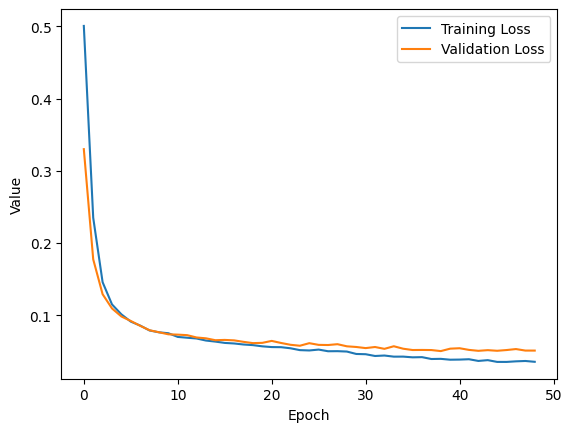

In [14]:
nn_model = DeepLearningModel(x_train, z_train,last_layer_activation='sigmoid',loss_fn='binary_crossentropy')
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = nn_model.fit(x_train, z_train, epochs=500, batch_size=128, validation_data=(x_test, z_test), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

# SSL Step 2: Fine-tuning using few amount of actual fault labels

In [15]:

x_train,y_train,z_val= Resample(X_sc,Y,Z,8)
y_train = ohe.transform(y_train.reshape(-1,1))


fine_tuned_model = FineTunedModel(nn_model,x_train,y_train,X_sc,Y_ohe)

Y_pred = fine_tuned_model.predict(X_sc)
Y_pred = ohe.inverse_transform(Y_pred)
f1 = f1_score(Y, Y_pred, average='macro') 
print(f'F1 score on whole dataset = {f1}')

F1 score on whole dataset = 0.8017315908658382


# XAI using occlusion

In [16]:
def mae(A, B):
    # Ensure A and B are numpy arrays
    A = np.array(A)
    B = np.array(B)

    # Calculate the cross-entropy loss
    loss = np.abs(A-B)
    loss = np.sum(loss,axis=1) # Adding a small epsilon to avoid division by zero
    return loss

In [17]:
def Occlusion_feature_importance(x_fault,fine_tuned_model):
    """
    Calculate the normalized occlusion feature importance for each feature in a given input dataset.

    Parameters:
    - x_fault (numpy.ndarray): Input dataset with shape (samples, timesteps, features).
    - fine_tuned_model (keras.Model): A trained neural network model.

    Returns:
    numpy.ndarray: Normalized occlusion feature importance scores for each feature.
                  The shape of the output array is (samples, features).
                  Each entry represents the normalized importance of a feature in the corresponding sample.

    This function computes the feature importance by iteratively occluding each feature and measuring the change
    in model predictions. The importance score is normalized across features for each sample.
    
    """
    occ_Feature_importance = np.zeros(shape=(len(x_fault),x_fault.shape[2]))

    y_pred = fine_tuned_model.predict(x_fault)
    for feature in range(x_fault.shape[2]):
        
        x_occ = x_fault.copy()
        x_occ[:,:,feature] = np.zeros([x_fault.shape[0],x_fault.shape[1]])
        y_occ = fine_tuned_model.predict(x_occ,verbose=0)
        FI = mae(y_pred, y_occ)
        occ_Feature_importance[:,feature] = FI

    S = np.sum(occ_Feature_importance, axis=1)
    S = S[:, np.newaxis]  # Reshape S to have one column
    normalized_occ_Feature_importance = occ_Feature_importance / S
    return normalized_occ_Feature_importance



# Realtime importance generation using BG-XAI

In [26]:
''' Process data from a CSV file, extract relevant time intervals for a specific fault, 
    perform preprocessing, and visualize occurrence using occlusion feature importance. '''

data = pd.read_csv("Electrolyzer_faults.csv")
fault_no=4 #[0,1,2,3,4,5,6,7,8,9]

arr_df= data[(data['time'] >= int(f'{fault_no-1}80')) & (data['time'] <= int(f'{fault_no}80'))] #4,9

X,Y,_,Time =preprocess_inferance(arr_df,sc,window_size=10, stride=1)

normalized_occ_FI = Occlusion_feature_importance(X,fine_tuned_model)

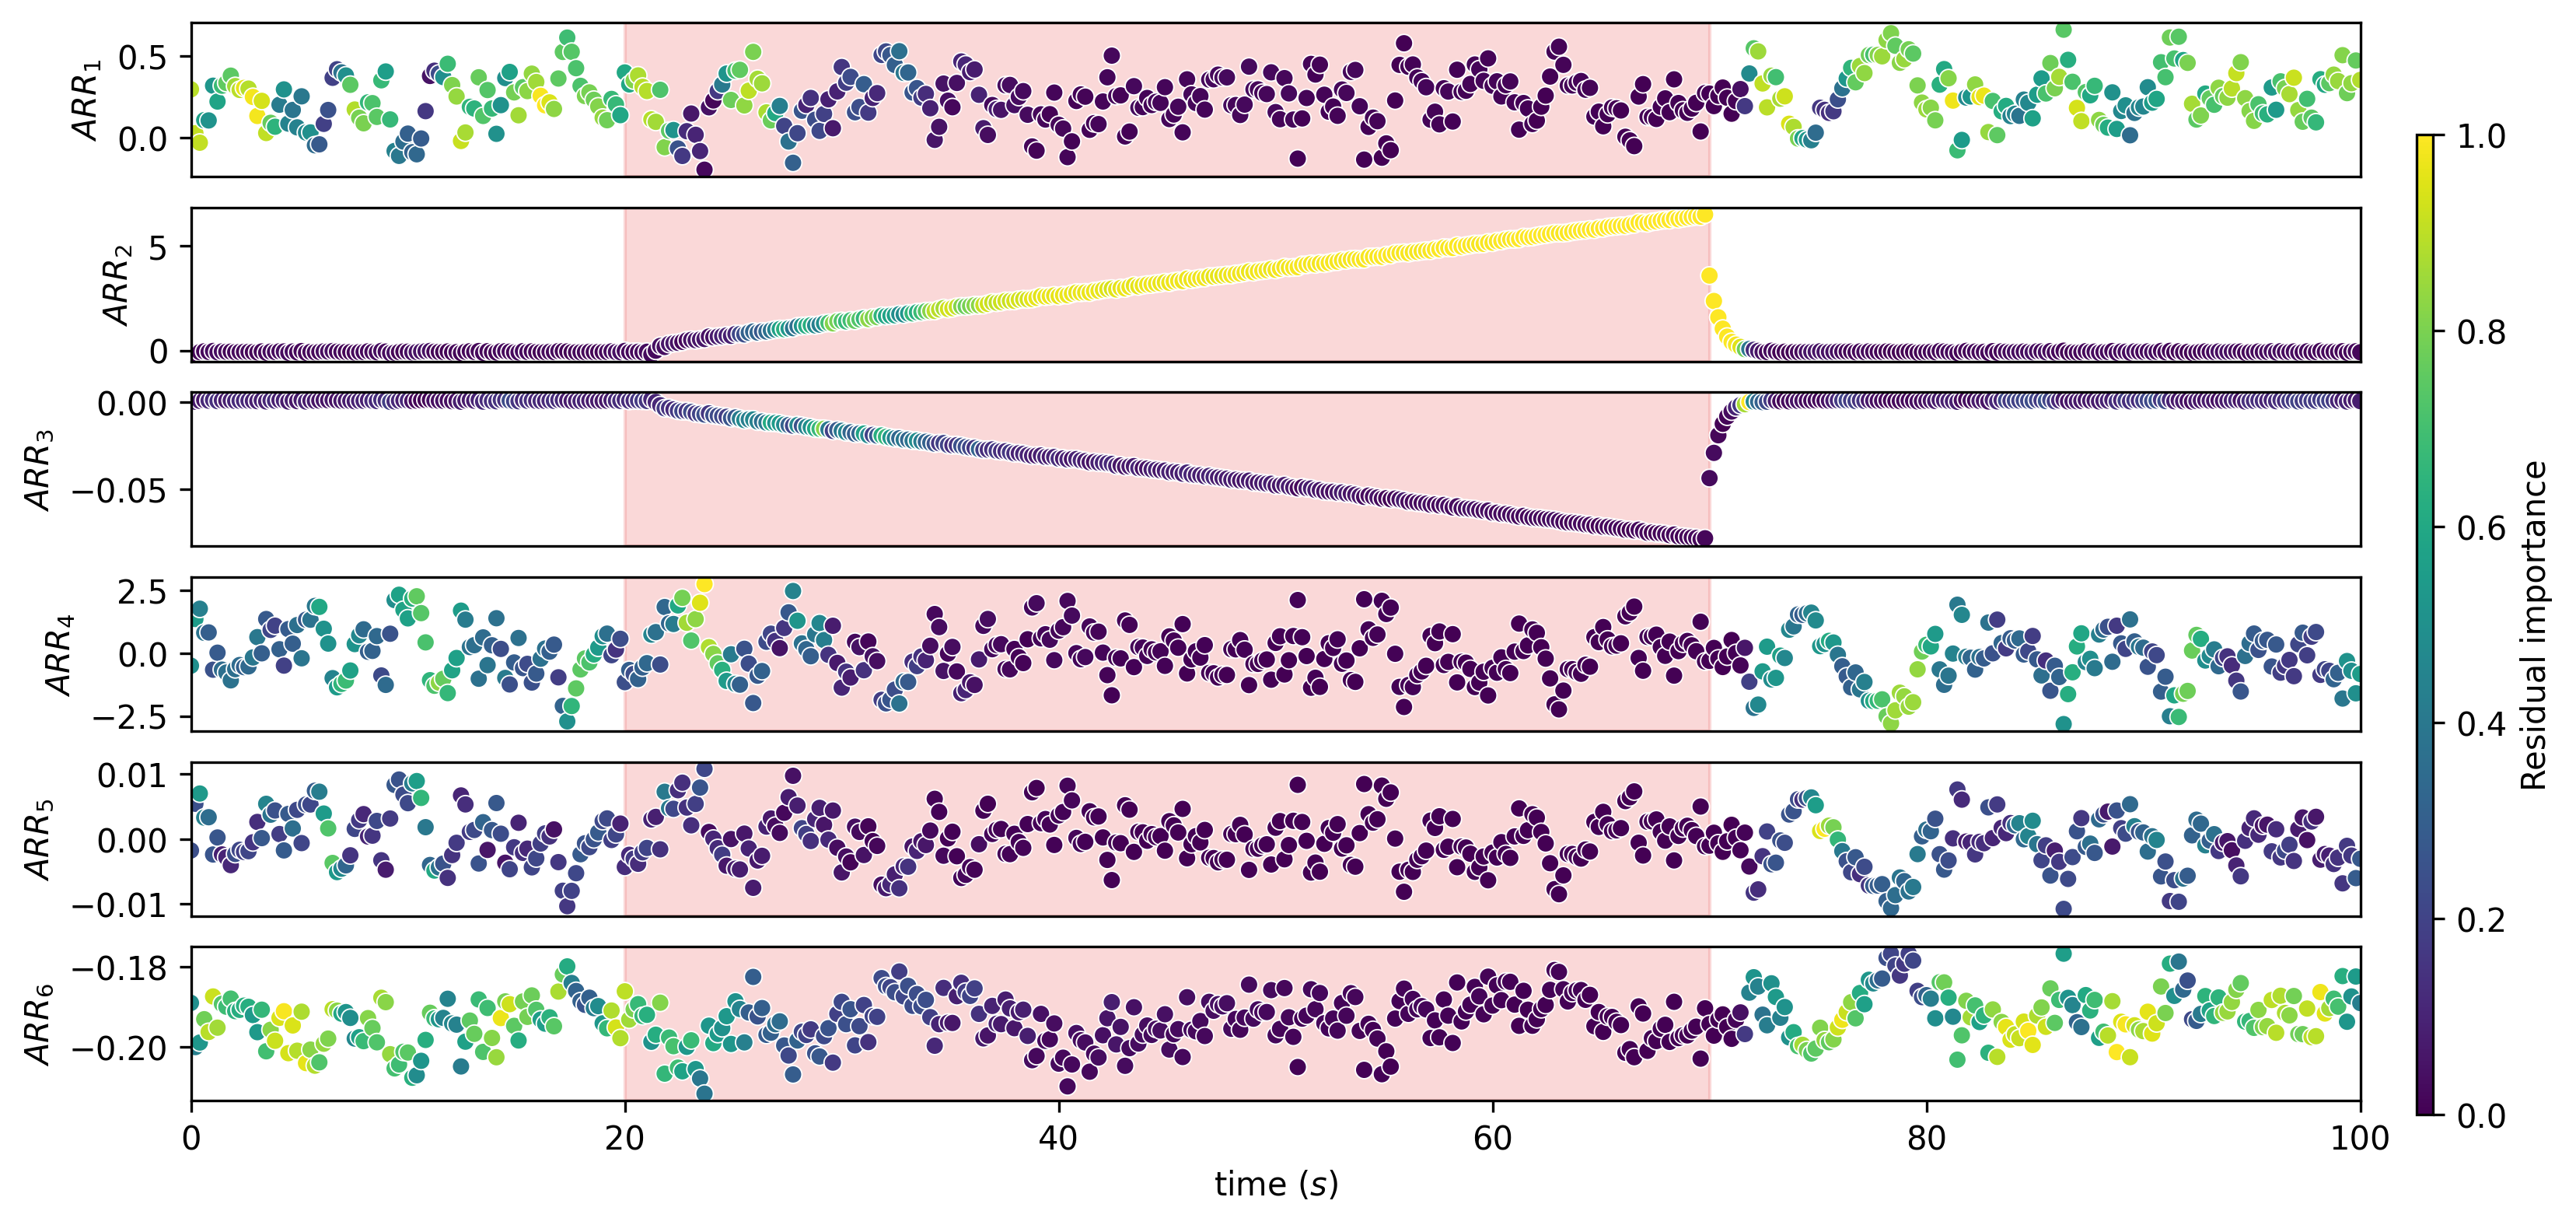

In [27]:
# Define the values of 'f' you want to create subplots for
values_of_f = [0, 1, 2, 3, 4, 5]  # Adjust as needed

# Create subplots for each value of 'f'
fig, axs = plt.subplots( len(values_of_f), 1, figsize=(12, 6), dpi=300)
cmap = plt.get_cmap("viridis")
# Loop over the values of 'f' and create scatter plots
for i, f in enumerate(values_of_f):
    ds = 1
    ax = axs[i]
    
    # Create a scatter plot for the current 'f'
    ax.axvspan(20, 70, color='lightcoral', alpha=0.3)
    sns.scatterplot(x = np.linspace(0,100,len(Time[::ds])), y=X[::ds, -1, f], hue=normalized_occ_FI[::ds, f], ax=ax, markers=True,palette=cmap, s=30)
    ax.get_legend().remove()
    ax.set_ylabel(f'$ARR_{i+1}$')
    ax.set_xlim([0,100])
    ax.grid(False)
    if i + 1 < 6:
        ax.set_xticks([])  # Hide x-ticks for all subplots except the last one
ax.set_xlabel('time ($s$)')   

# Create the global color bar
cbar_ax = fig.add_axes([0.92, 0.1, 0.006, 0.7])
cb = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=cbar_ax, orientation='vertical')
cb.set_label('Residual importance')
# # Display the subplots
# Increase DPI and save the figure
# fig.savefig('Plots/Occlusion_Tst_fault.pdf', dpi=300,bbox_inches='tight')
plt.show()